## 2D Scan Matcher

In [1]:
import numpy as np
from scipy.spatial import cKDTree
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import matplotlib.pyplot as plt
# %matplotlib notebook
# plt.interactive(False)

### Load Laser Data

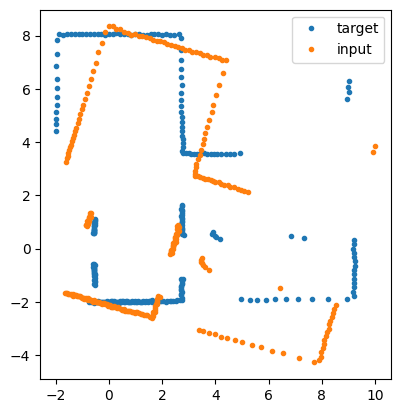

In [4]:
# plt.close()

angle_min = -2.35619449615
angle_max = 2.35619449615
angle_increment = 0.0174532923847
range_max = 15.0
ranges1 = np.load("data/laserdata1.npy")
# print(ranges1)
ranges2 = np.load("data/laserdata2.npy")

x1 = ranges1 * np.cos(np.arange(angle_min, angle_max, angle_increment))
y1 = ranges1 * np.sin(np.arange(angle_min, angle_max, angle_increment))
pc1 = np.stack([x1,y1])

x2 = ranges2 * np.cos(np.arange(angle_min, angle_max, angle_increment))
y2 = ranges2 * np.sin(np.arange(angle_min, angle_max, angle_increment))
pc2 = np.stack([x2,y2])

plt.plot(pc1[0], pc1[1], '.')
plt.plot(pc2[0], pc2[1], '.')
plt.legend(["target", "input"])
plt.gca().set_aspect('equal')
plt.show()

### Find correspondnences

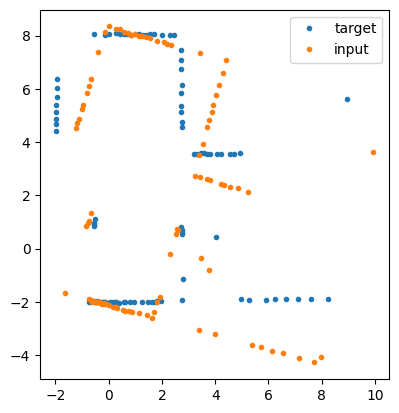

In [5]:
plt.close()

def find_correspondences(pc1, pc2):
    # construct correspondences
    tree = cKDTree(pc1.T)
    dd, ii = tree.query(pc2.T, k=1)
    pc2_to_pc1 = np.array( list(enumerate(ii)) )   # [pc2_index, pc1_index]

    # max distance threshold?

    # remove concurrences, leave only 1-1 mappings
    sort_mask = np.argsort(dd)
    pc2_to_pc1 = pc2_to_pc1
    _, unique_mask = np.unique(pc2_to_pc1[:,1], return_index=True)

    unique_pc2_to_pc1 = pc2_to_pc1[unique_mask]
    pc2_cor = pc2[:, unique_pc2_to_pc1[:,0]]
    pc1_cor = pc1[:, unique_pc2_to_pc1[:,1]]
    
    return pc1_cor, pc2_cor

pc1_cor, pc2_cor = find_correspondences(pc1, pc2)
_=plt.plot(pc1_cor[0], pc1_cor[1], '.')
_=plt.plot(pc2_cor[0], pc2_cor[1], '.')
_=plt.legend(["target", "input"])
_=plt.gca().set_aspect('equal')
plt.show()

## Align Point clouds

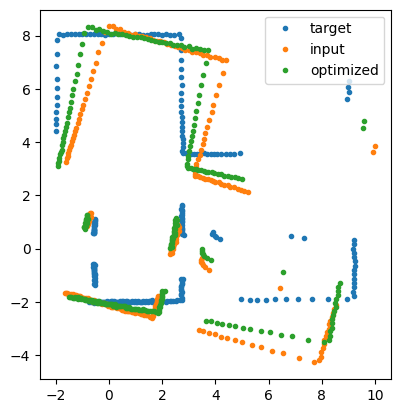

In [6]:
plt.close()

def align_svd(pc1, pc2):
    # normalize point clouds
    mu_pc1 = np.mean(pc1, axis=1)
    mu_pc2 = np.mean(pc2, axis=1)
    pc1_norm = pc1 - mu_pc1.reshape(-1, 1)
    pc2_norm = pc2 - mu_pc2.reshape(-1, 1)
    W = np.matmul(pc2_norm, pc1_norm.T)                         # calculate cross-covariance
    u, s, v_T = np.linalg.svd(W, full_matrices=True)            # decompose using SVD

    R = np.matmul(v_T.T, u.T)                                   # calculate rotation
    T = mu_pc1 - np.matmul(R, mu_pc2)                           # calculate translation
    
    return T.reshape(-1,1), R
    
T,R = align_svd(pc1_cor, pc2_cor)

pc3 = pc2 + T
pc3 = R @ pc2


_=plt.plot(pc1[0], pc1[1], '.')
_=plt.plot(pc2[0], pc2[1], '.')
_=plt.plot(pc3[0], pc3[1], '.')
_=plt.legend(["target", "input", "optimized"])
_=plt.gca().set_aspect('equal')
plt.show()


## Calculate odom

In [7]:
def calculate_odom(T, R):
    translation = T.reshape(1, -1) @ R
    rotation = np.arctan2(R[1,0], R[0,0])
    return translation, rotation
    
calculate_odom(T, R)

(array([[0.0191152 , 0.19439376]]), 0.09517297201781982)

## Scan matching in loop

Final translation: [[ 0.46394514 -0.08448615]] rotation: 0.2857715081801923


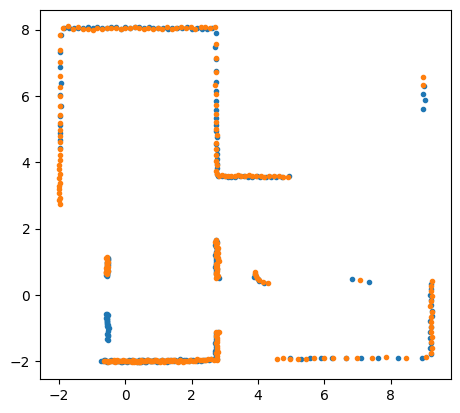

In [8]:
plt.close()

max_iter = 100
R_acc = np.eye(2)
T_acc = np.zeros((2,1))
for i in range(max_iter):
    pc1_cor, pc2_cor =  find_correspondences(pc1, R_acc @ pc2 + T_acc)
    T, R = align_svd(pc1_cor, pc2_cor)
    R_acc = R @ R_acc
    T_acc = T_acc + T
    
pc3 = R_acc @ pc2
pc3 += T_acc

tra, rot = calculate_odom(T_acc, R_acc)
print("Final translation:", tra, "rotation:", rot)
    

_=plt.plot(pc1[0], pc1[1], '.')
_=plt.plot(pc3[0], pc3[1], '.')
_=plt.gca().set_aspect('equal')
plt.show()

In [30]:
from matplotlib.animation import PillowWriter

class Plotter:
    def __init__(self, pc1, pc2, max_iter=100):
        self.max_iter = max_iter
        self.pc1 = pc1
        self.pc2 = pc2
        self.R_acc = np.eye(2)
        self.T_acc = np.zeros((2,1))
        self.fig, self.ax = plt.subplots()
    
    def init(self):
        self.points1, = plt.plot(self.pc1[0], self.pc1[1], '.')
        self.points2, = plt.plot([], [], '.')
        self.ax.set_aspect('equal')
        return self.points1, self.points2,

    def update(self, frame):
        pc1_cor, pc2_cor =  find_correspondences(self.pc1, self.R_acc @ self.pc2 + self.T_acc)
        T, R = align_svd(pc1_cor, pc2_cor)
        self.T_acc = self.T_acc + T
        self.R_acc = R @ self.R_acc
        
        pc3 = self.R_acc @ self.pc2
        pc3 = pc3 + self.T_acc

        self.points2.set_data(pc3[0], pc3[1])
        return self.points1, self.points2,
        
    def animate(self):
        ani = FuncAnimation(self.fig, self.update, frames=self.max_iter,
                            init_func=self.init, blit=True, interval=200)
      
        return ani

 
sm_plot = Plotter(pc1, pc2, 20)
ani = sm_plot.animate()
ani.save("ScanMatch.gif", writer=PillowWriter(fps=20))
plt.close()
# HTML(sm_plot.animate().to_html5_video())

## Extra (With momentum)

In [33]:
class Plotter:
    def __init__(self, pc1, pc2, max_iter=100, bias_correction=True):
        self.max_iter = max_iter
        self.pc1 = pc1
        self.pc2 = pc2
        self.bias_correction = bias_correction
        self.R_acc = np.eye(2)
        self.T_acc = np.zeros((2,1))
        self.fig, self.ax = plt.subplots()
        
        self.R_v = np.eye(2)
        self.T_v = np.zeros((2,1))
    
    def init(self):
        self.points1, = plt.plot(self.pc1[0], self.pc1[1], '.')
        self.points2, = plt.plot([], [], '.')
        self.ax.set_aspect('equal')
        return self.points1, self.points2,

    def update(self, t):
        pc1_cor, pc2_cor =  find_correspondences(self.pc1, self.R_acc @ self.pc2 + self.T_acc)
        T, R = align_svd(pc1_cor, pc2_cor)
        
        alpha = 0.95
        
        if self.bias_correction:
            alpha_cor = np.log(t+1)/10.0*alpha
        else:
            alpha_cor = alpha
            
        self.T_v = T*(1-alpha_cor) + self.T_v*alpha_cor 
        self.R_v = R*(1-alpha_cor) + self.R_v*alpha_cor
        
        self.T_acc = self.T_acc + self.T_v
        self.R_acc = self.R_v @ self.R_acc
        
        pc3 = self.R_acc @ self.pc2
        pc3 = pc3 + self.T_acc

        self.points2.set_data(pc3[0], pc3[1])
        return self.points1, self.points2,
        
    def animate(self):
        ani = FuncAnimation(self.fig, self.update, frames=self.max_iter,
                            init_func=self.init, blit=True, interval=200)
        return ani

In [34]:
# Without Bias Correction
plt.close()
sm_extra_plot = Plotter(pc1, pc2, 50, bias_correction=False)
ani = sm_extra_plot.animate()
ani.save("ScanMatchWithoutBiasCorrection.gif", writer=PillowWriter(fps=20))
plt.close()

In [35]:
# With Bias Correction
plt.close()
sm_extra_plot = Plotter(pc1, pc2, 20, bias_correction=True)
ani = sm_extra_plot.animate()
ani.save("ScanMatchWithBiasCorrection.gif", writer=PillowWriter(fps=20))
plt.close()